In [6]:
#Importing libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import squarify 
import matplotlib.dates as dates 
from datetime import datetime
import xgboost as xgboost 

In [7]:
data = pd.read_csv('commerce_data.csv')
data.head()

,time,event_name,product_id,category_id,category_name,brand,price,user_id,session,category_1,category_2,category_3
0,2019-12-16 02:00:59+09,view,5748490,1487580006350586771,appliances.environment.vacuum,Not defined,26.97,527803604,1c8250d5-79e6-4080-aa13-d2e73c596fa2,appliances,environment,vacuum
1,2019-12-16 02:01:23+09,view,5856191,1487580006350586771,appliances.environment.vacuum,runail,24.44,587394396,2721b750-3936-4196-ba9b-206e823f725d,appliances,environment,vacuum
2,2019-12-16 02:01:56+09,view,5867188,1487580006350586771,appliances.environment.vacuum,emil,55.56,527803604,1c8250d5-79e6-4080-aa13-d2e73c596fa2,appliances,environment,vacuum
3,2019-12-16 02:05:17+09,view,5826657,1487580006350586771,appliances.environment.vacuum,Not defined,29.71,527803604,1c8250d5-79e6-4080-aa13-d2e73c596fa2,appliances,environment,vacuum
4,2019-12-16 02:05:38+09,view,8098,1487580006350586771,appliances.environment.vacuum,Not defined,1.11,587355096,79c56618-fb25-41f2-87c9-bbc55880c884,appliances,environment,vacuum


In [8]:
df = data.drop(['time','product_id','category_id', 'category_name', 'brand','user_id', 'session', 'category_1', \
         'category_2', 'category_3' ], axis=1)
df.head()

,event_name,price
0,view,26.97
1,view,24.44
2,view,55.56
3,view,29.71
4,view,1.11


In [9]:
df.head()

,event_name,price
0,view,26.97
1,view,24.44
2,view,55.56
3,view,29.71
4,view,1.11


In [10]:
df.isnull().sum()

event_name    0
price         0
dtype: int64

In [11]:
df.dtypes

event_name     object
price         float64
dtype: object

In [12]:
df = df[df.price != 0]
df.head()
df.count()

event_name    3525697
price         3525697
dtype: int64

In [13]:
found = df['price'].isin([0])
df1 = pd.DataFrame({'price': found})
df1['price'].value_counts()

False    3525697
Name: price, dtype: int64

In [14]:
df = df[df.event_name != 'cart']
df = df[df.event_name != 'view']
df.head(100)

,event_name,price
8,remove_from_cart,4.16
10,remove_from_cart,1.11
11,purchase,1.27
12,purchase,24.60
22,remove_from_cart,24.60
...,...,...
594,remove_from_cart,24.44
595,remove_from_cart,24.44
597,remove_from_cart,46.83
598,remove_from_cart,46.83


In [15]:
df.dtypes

event_name     object
price         float64
dtype: object

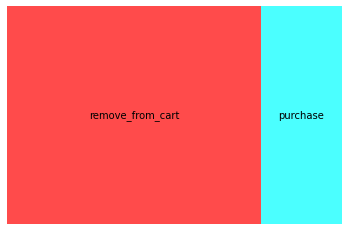

In [16]:
top_event = df.loc[:,'event_name'].value_counts().sort_values(ascending=False)
squarify.plot(sizes=top_event, label = top_event.index.array, color=["red","cyan","green","blue"], alpha=.7)
plt.axis('off')
plt.show()

### XGBoost 

In [17]:
# Isolate the X and Y varaibles 
y = df.iloc[:,0]
x = df._get_numeric_data()
print(y)
#print(x)

8          remove_from_cart
10         remove_from_cart
11                 purchase
12                 purchase
22         remove_from_cart
                 ...       
3533270    remove_from_cart
3533271    remove_from_cart
3533272    remove_from_cart
3533278    remove_from_cart
3533279    remove_from_cart
Name: event_name, Length: 877516, dtype: object


In [18]:
from sklearn.model_selection import train_test_split

In [32]:
#Split dataset into training and test set 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .9, random_state = 3525696 )
print(x_train)
print('NEXT',x_test)
print('NEXT', y_train)
print('NEXT', y_test)

         price
661312    3.00
2899609   3.02
407648    1.75
3073055   5.62
2441813   1.59
...        ...
2630979   5.49
447875   12.54
2455563   3.97
305267    0.79
2808452   3.16

[87751 rows x 1 columns]
NEXT          price
1236634   7.78
331680   16.67
3319350   2.37
970019    4.05
1149362   3.14
...        ...
1252943   6.49
2985125   0.79
695110    5.56
1662357   2.05
914078    1.02

[789765 rows x 1 columns]
NEXT 661312     remove_from_cart
2899609    remove_from_cart
407648     remove_from_cart
3073055    remove_from_cart
2441813            purchase
                 ...       
2630979    remove_from_cart
447875     remove_from_cart
2455563            purchase
305267     remove_from_cart
2808452            purchase
Name: event_name, Length: 87751, dtype: object
NEXT 1236634    remove_from_cart
331680     remove_from_cart
3319350    remove_from_cart
970019     remove_from_cart
1149362    remove_from_cart
                 ...       
1252943    remove_from_cart
2985125    remove_fro

In [34]:
#Transform y factor to variable 
y_train = np.where(y_train == 'remove_from_cart', 1, 0)
y_test = np.where(y_test == 'remove_from_cart', 1, 0)
print(y_train)
print(y_test)
print(np.mean(y_train))
np.mean(y_test)

[1 1 1 ... 0 1 0]
[1 1 1 ... 0 0 1]
0.757073993458764


0.7570682418187689

In [35]:
#Create xgboost matrices 
Train = xgboost.DMatrix(x_train, label = y_train)
Test = xgboost.DMatrix(x_test, label = y_test)
print(Train)
print(Test)

In [36]:
#Setting parameters 
parameters1 = {'learning_rate': 0.3, 
              'max_depth': 2,
              'colsample_bytree': 1, 
               'subsample': 1, 
               'min_child_weight': 1,
               'gamma' : 0,
               'random_state' : 3525696, 
               'eval_metric': 'auc',
               'objective': 'binary:logistic'}

In [37]:
#Run xgboost 
model1 = xgboost.train(params = parameters1, 
                      dtrain = Train, 
                      num_boost_round = 500, 
                      evals = [(Test, 'Yes')],
                      verbose_eval = 50)

[0]	Yes-auc:0.53300
[50]	Yes-auc:0.55773
[100]	Yes-auc:0.56085
[150]	Yes-auc:0.56179
[200]	Yes-auc:0.56261
[250]	Yes-auc:0.56289
[300]	Yes-auc:0.56315
[350]	Yes-auc:0.56334
[400]	Yes-auc:0.56398
[450]	Yes-auc:0.56407
[499]	Yes-auc:0.56413


In [24]:
#Predictions 
predictions1 = model1.predict(Test)
predictions1 = np.where(predictions1 > 0.8, 1, 0)
print(predictions1)

[0 0 0 ... 1 1 0]


In [27]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
confusion_matrix1 = confusion_matrix(y_test, predictions1)
print(confusion_matrix1)

[[157677  34182]
 [452605 145301]]


In [29]:
report1 = classification_report(y_test, predictions1)
print(report1)

              precision    recall  f1-score   support

           0       0.26      0.82      0.39    191859
           1       0.81      0.24      0.37    597906

    accuracy                           0.38    789765
   macro avg       0.53      0.53      0.38    789765
weighted avg       0.68      0.38      0.38    789765



In [31]:
#################################
#Isolate the categorical variables 
dataset_categorical = df.select_dtypes(exclude = 'number')
print(dataset_categorical)

               event_name
8        remove_from_cart
10       remove_from_cart
11               purchase
12               purchase
22       remove_from_cart
...                   ...
3533270  remove_from_cart
3533271  remove_from_cart
3533272  remove_from_cart
3533278  remove_from_cart
3533279  remove_from_cart

[877516 rows x 1 columns]


In [ ]:
#Transform categorical varaibles into dummy variables 
dataset_categorical = pd.get_dummies()

In [18]:
#activity = df.groupby(['price', 'event_name'], as_index=False)
#activity.head()
#activity.count()

,event_name,price
0,view,26.97
1,view,24.44
2,view,55.56
3,view,29.71
4,view,1.11
...,...,...
3532214,cart,21.16
3532281,cart,21.16
3532555,view,25.70
3533227,view,28.02


In [22]:
#df_targets = activity.merge(price, event_name)
#df_targets['price'] = df_targets['price'].fillna(0)
#df_targets.drop(df_targets.columns[[2]], axis =1, inplace= True)
#df_targets = df_targets.rename(columns={'event_name_x':'event_name'})
#df_targets.head()

AttributeError: 'DataFrameGroupBy' object has no attribute 'merge'

In [24]:
#activity = activity.merge(activity, on='price', how='left')
#activity['event_name'] = activity['event_name'].fillna(0)
#activity.head()

AttributeError: 'DataFrameGroupBy' object has no attribute 'merge'

In [ ]:
#df_targets.to_csv('training_data.csv')

In [ ]:
#df_targets.info()